In [10]:
# pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from PIL import Image
import os

In [3]:
def load_image(infilename):
    """This function loads an image into memory when you give it
       the path of the image
    """
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="float32")
    
    if data.shape[2] == 4:
        data = np.delete(data, 3, 2)
        
    return data, data.shape


def create_npy_from_image(images_class, st, en):
    """Loops through the images in a folder and saves all of them
       as a numpy array in output_name
    """

    data = []
    print("##############################################")
    print(f"class: {images_class}")
    for i in range(st, en+1):
        img, shape = load_image(f'./data/{images_class}/{images_class}{i}.png')
        data.append(img)
        if (i-1)%100 == 0:
            print(f"image number {i}: shape is {shape}")
    
    # filename.endswith(".jpg"):
    return np.array(data, dtype=np.object_)
    # return data

In [4]:
train_set, test_set = 250, 50
img_classes = ["cloth", "no_mask"]
train_data = []
test_data = []
for img_cl in img_classes:
    train_data.append(create_npy_from_image(img_cl, 1, train_set))
    test_data.append(create_npy_from_image(img_cl, train_set+1, train_set+test_set))

##############################################
class: cloth
image number 1: shape is (128, 128, 3)
image number 101: shape is (128, 128, 3)
image number 201: shape is (128, 128, 3)
##############################################
class: cloth
##############################################
class: no_mask
image number 1: shape is (128, 128, 3)
image number 101: shape is (128, 128, 3)
image number 201: shape is (128, 128, 3)
##############################################
class: no_mask


In [5]:
train_features = torch.Tensor(np.concatenate(train_data, axis=0).astype(np.int32))
train_targets = torch.Tensor(np.concatenate(([0 for i in range(train_set)], [1 for i in range(train_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

test_features = torch.Tensor(np.concatenate(test_data, axis=0).astype(np.int32))
test_targets = torch.Tensor(np.concatenate(([0 for i in range(test_set)], [1 for i in range(test_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

In [6]:
train_data = data_utils.TensorDataset(train_features, train_targets)
test_data = data_utils.TensorDataset(test_features, test_targets)

In [7]:
model = nn.Sequential(
    nn.Linear(49152, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=49152, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
batch_size = 200
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=1, 
                                           shuffle=True)

In [12]:
# Train the model
n_epochs = 10

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)

        # reshape the input
        inputs = inputs.view(-1, 49152)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
  
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)
        inputs = inputs.view(-1, 49152)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 1975.2698, Test Loss: 1204.1021
Epoch 2/10, Train Loss: 567.4139, Test Loss: 563.6931
Epoch 3/10, Train Loss: 395.8399, Test Loss: 677.3283
Epoch 4/10, Train Loss: 335.5393, Test Loss: 203.0125
Epoch 5/10, Train Loss: 217.7691, Test Loss: 154.3324
Epoch 6/10, Train Loss: 132.8512, Test Loss: 160.4039
Epoch 7/10, Train Loss: 46.7537, Test Loss: 66.7620
Epoch 8/10, Train Loss: 29.8721, Test Loss: 111.9380
Epoch 9/10, Train Loss: 25.2233, Test Loss: 31.6735
Epoch 10/10, Train Loss: 38.2820, Test Loss: 99.6245


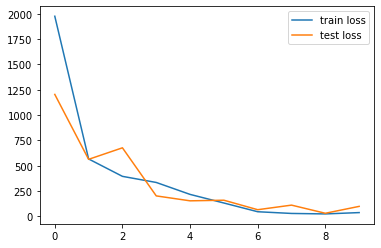

In [13]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()